# 1D CNN-based AEs (CAE) for 2.4Kb windows

In this notebook I am comparing 4 different kind of CAE's that compress the 24-bin long genomic windows to 6 and 4 latent dimensions.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [14]:
import numpy as np
import os
import sys
import warnings
warnings.filterwarnings('ignore')

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

assembly = 'hg19'
window_size = 2400
step_size = window_size / 2
aggregation = 100
chroms = [
    # Training
    'chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10',
    # Testing
    'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX',
]

## Load and normalize the data

#### Download dataset

In [6]:
import wget
from pathlib import Path

Path('data').mkdir(parents=True, exist_ok=True) 

print('Download data...')

# GM12878 DNase-seq read-depth normalized signal
bw = 'data/ENCFF158GBQ.bigWig'
if not Path(bw).is_file():
    wget.download(
        'https://www.encodeproject.org/files/ENCFF158GBQ/@@download/ENCFF158GBQ.bigWig',
        'data/ENCFF158GBQ.bigWig',
    )

print('Done!')

Download data...
Done!


#### Retrieved binned genomic windows

In [ ]:
from ae import bigwig

data = bigwig.chunk(
    bw,
    window_size,
    step_size,
    aggregation,
    chroms,
    verbose=True,
)

#### Merge data into a training and test set

In [9]:
num_training = 10

train_num = 0
test_num = 0

for i in range(num_training):
    train_num += data[i].shape[0]

for i in range(num_training, len(data)):
    test_num += data[i].shape[0]
    
data_train = np.zeros((train_num, window_size // aggregation))
data_test = np.zeros((test_num, window_size // aggregation))

k = 0
for i in range(num_training):
    l = k + data[i].shape[0]
    data_train[k:l,] = data[i]
    k = l

k = 0
for i in range(num_training, len(data)):
    l = k + data[i].shape[0]
    data_test[k:l,] = data[i]
    k = l

#### Cap data at 99.9th percentile and normalize to `[0,1]`

In [10]:
"""Normalization"""

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.preprocessing.data import QuantileTransformer

cutoff = np.percentile(data_train, (0, 99.9))
data_train_norm = np.copy(data_train)
data_train_norm[np.where(data_train_norm < cutoff[0])] = cutoff[0]
data_train_norm[np.where(data_train_norm > cutoff[1])] = cutoff[1]

cutoff = np.percentile(data_test, (0, 99.9))
data_test_norm = np.copy(data_test)
data_test_norm[np.where(data_test_norm < cutoff[0])] = cutoff[0]
data_test_norm[np.where(data_test_norm > cutoff[1])] = cutoff[1]

print(
    'Train Max: {}'.format(np.max(data_train_norm)),
    'Test Max:  {}'.format(np.max(data_test_norm)),
)

data_train_norm = MinMaxScaler().fit_transform(data_train_norm)
data_test_norm = MinMaxScaler().fit_transform(data_test_norm)

Train Max: 1.453673955798149 Test Max:  1.9262399836242199


#### Filter genomic windows by total signal

In [12]:
threshold = 2

train_sum = np.sum(data_train_norm, axis=1)
final_train = data_train_norm[np.where(train_sum > threshold)]

test_sum = np.sum(data_test_norm, axis=1)
final_test = data_test_norm[np.where(test_sum > threshold)]

print(
    '{} out of {} training windows have a total signal of at least {}.'.format(
        final_train.shape[0], data_train_norm.shape[0], threshold
    )
)
print(
    '{} out of {} test windows have a total signal of at least {}.'.format(
        final_test.shape[0], data_test_norm.shape[0], threshold
    )
)

21934 out of 410374 training windows have a total signal of at least 2.
6365 out of 132726 test windows have a total signal of at least 2.


## Define CAEs

#### Load existing models

In [ ]:
# ...

#### Define CAEs

In [13]:
from ae.cnn import cnn, cnn2, cnn3

encoder1, decoder1, autoencoder1 = cnn2(
    (window_size // aggregation, 1),
        filters=[32, 64, 128, 6],
    kernel_sizes=[11, 7, 3],
    summary=False,
    dr=True
)

encoder1b, decoder1b, autoencoder1b = cnn2(
    (window_size // aggregation, 1),
    filters=[32, 64, 128, 4],
    kernel_sizes=[11, 7, 3],
    summary=False,
    dr=True
)

encoder2, decoder2, autoencoder2 = cnn3(
    window_size // aggregation,
    optimizer='adadelta',
    loss='binary_crossentropy',
    cfilters=[32, 64, 128],
    ckernel_sizes=[11, 7, 3],
    dunits=[384, 96, 24],
    embedding=6,
    dropouts=[0.0, 0.0, 0.0],
    summary=False
)

encoder2b, decoder2b, autoencoder2b = cnn3(
    window_size // aggregation,
    optimizer='adadelta',
    loss='binary_crossentropy',
    cfilters=[32, 64, 128],
    ckernel_sizes=[11, 7, 3],
    dunits=[384, 192, 96, 48, 24, 12],
    embedding=4,
    dropouts=[0.0, 0.0, 0.0, 0.2, 0.1, 0.05, 0.01, 0.01, 0.01],
    reg_lambda=0.0001,
    summary=False
)

Using TensorFlow backend.


#### Train the CAEs

In [ ]:
from ae.utils import train

epochs = 1
batch_size = 256

train(
    autoencoder1,
    final_train.reshape(final_train.shape[0], final_train.shape[1], 1),
    final_test.reshape(final_test.shape[0], final_test.shape[1], 1),
    epochs=epochs,
    batch_size=batch_size,
)

train(
    autoencoder1b,
    final_train.reshape(final_train.shape[0], final_train.shape[1], 1),
    final_test.reshape(final_test.shape[0], final_test.shape[1], 1),
    epochs=epochs,
    batch_size=batch_size,
)

train(
    autoencoder2,
    final_train.reshape(final_train.shape[0], final_train.shape[1], 1),
    final_test.reshape(final_test.shape[0], final_test.shape[1], 1),
    epochs=epochs,
    batch_size=batch_size,
)

train(
    autoencoder2b,
    final_train.reshape(final_train.shape[0], final_train.shape[1], 1),
    final_test.reshape(final_test.shape[0], final_test.shape[1], 1),
    epochs=epochs,
    batch_size=batch_size,
)

Train on 38034 samples, validate on 9754 samples
Epoch 1/100
38034/38034 [==============================] - 10s 254us/step - loss: 0.4855 - val_loss: 0.4243
Epoch 2/100
38034/38034 [==============================] - 6s 164us/step - loss: 0.4224 - val_loss: 0.3991
Epoch 3/100
38034/38034 [==============================] - 7s 176us/step - loss: 0.4096 - val_loss: 0.3916
Epoch 4/100
38034/38034 [==============================] - 7s 179us/step - loss: 0.4011 - val_loss: 0.3766
Epoch 5/100
38034/38034 [==============================] - 10s 261us/step - loss: 0.3934 - val_loss: 0.3805
Epoch 6/100
38034/38034 [==============================] - 11s 282us/step - loss: 0.3880 - val_loss: 0.3673
Epoch 7/100
38034/38034 [==============================] - 8s 218us/step - loss: 0.3846 - val_loss: 0.3643
Epoch 8/100
38034/38034 [==============================] - 9s 231us/step - loss: 0.3822 - val_loss: 0.3631
Epoch 9/100
38034/38034 [==============================] - 8s 219us/step - loss: 0.3802 - va

#### Save models

_Make sure not to overwrite previously saved models!_

In [136]:
# encoder1.save('../data/models/encode-gm12878-dnase-seq-2011-encoder-2kb-cae1.h5')
# decoder1.save('../data/models/encode-gm12878-dnase-seq-2011-decoder-2kb-cae1.h5')
# autoencoder1.save('../data/models/encode-gm12878-dnase-seq-2011-autoencoder-2kb-cae1.h5')

# encoder1b.save('../data/models/encode-gm12878-dnase-seq-2011-encoder-2kb-cae1b.h5')
# decoder1b.save('../data/models/encode-gm12878-dnase-seq-2011-decoder-2kb-cae1b.h5')
# autoencoder1b.save('../data/models/encode-gm12878-dnase-seq-2011-autoencoder-2kb-cae1b.h5')

# encoder2.save('../data/models/encode-gm12878-dnase-seq-2011-encoder-2kb-cae2.h5')
# decoder2.save('../data/models/encode-gm12878-dnase-seq-2011-decoder-2kb-cae2.h5')
# autoencoder2.save('../data/models/encode-gm12878-dnase-seq-2011-autoencoder-2kb-cae2.h5')

# encoder2b.save('../data/models/encode-gm12878-dnase-seq-2011-encoder-2kb-cae2b.h5')
# decoder2b.save('../data/models/encode-gm12878-dnase-seq-2011-decoder-2kb-cae2b.h5')
# autoencoder2b.save('../data/models/encode-gm12878-dnase-seq-2011-autoencoder-2kb-cae2b.h5')

## Predict signal

In [106]:
from keras.metrics import binary_crossentropy
from ae.utils import predict

predicted1, loss1, _ = predict(
    encoder1,
    decoder1,
    data_test_norm.reshape(data_test_norm.shape[0], data_test_norm.shape[1], 1),
    validator=binary_crossentropy
)
predicted1 = predicted1.reshape(predicted1.shape[0], predicted1.shape[1])

predicted1b, loss1b, _ = predict(
    encoder1b,
    decoder1b,
    data_test_norm.reshape(data_test_norm.shape[0], data_test_norm.shape[1], 1),
    validator=binary_crossentropy
)
predicted1b = predicted1b.reshape(predicted1b.shape[0], predicted1b.shape[1])

predicted2, loss2, _ = predict(
    encoder2,
    decoder2,
    data_test_norm.reshape(data_test_norm.shape[0], data_test_norm.shape[1], 1),
    validator=binary_crossentropy
)
predicted2 = predicted2.reshape(predicted2.shape[0], predicted2.shape[1])

predicted2b, loss2b, _ = predict(
    encoder2b,
    decoder2b,
    data_test_norm.reshape(data_test_norm.shape[0], data_test_norm.shape[1], 1),
    validator=binary_crossentropy
)
predicted2b = predicted2b.reshape(predicted2b.shape[0], predicted2b.shape[1])

## Visualize predictions

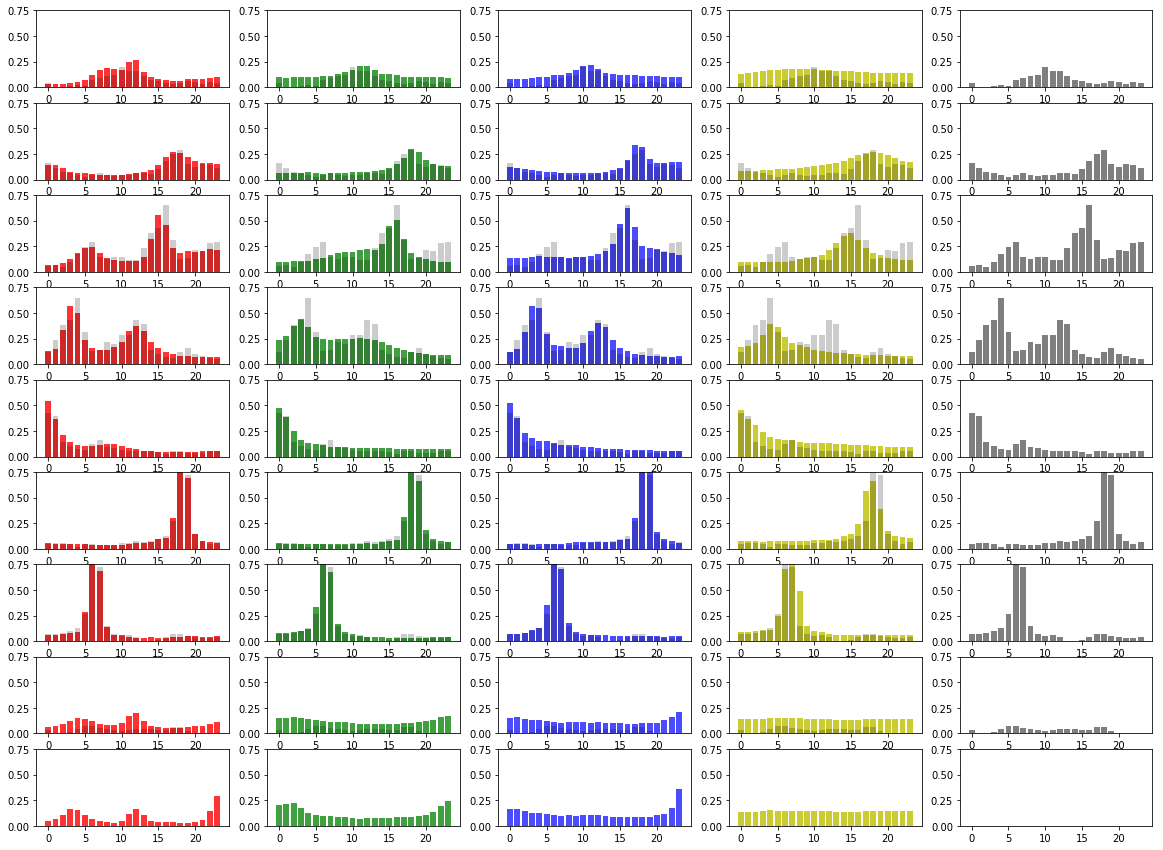

In [133]:
from keras.metrics import binary_crossentropy, kullback_leibler_divergence, mse
from keras import backend as K
import matplotlib.pyplot as plt

i = win_offset + 31688 # Interesting regions at 2.4KB windows at Chr22

N = np.arange(data_test_norm[0].size)
K = 9
y_max = 0.75
d = np.vstack((
    data_test_norm[i: i + K - 1],
    np.zeros(data_test_norm[0].size).reshape((1, data_test_norm[0].size))
))

plt.figure(figsize=(20, 15))
for k in range(K):
    encoded_1 = encoder1.predict(d[k].reshape((1, 24, 1)))
    decoded_1 = decoder1.predict(encoded_1).reshape(d[k].shape)

    encoded_1b = encoder1b.predict(d[k].reshape((1, 24, 1)))
    decoded_1b = decoder1b.predict(encoded_1b).reshape(d[k].shape)

    encoded_2 = encoder2.predict(d[k].reshape((1, 24, 1)))
    decoded_2 = decoder2.predict(encoded_2).reshape(d[k].shape)
    
    encoded_2b = encoder2b.predict(d[k].reshape((1, 24, 1)))
    decoded_2b = decoder2b.predict(encoded_2b).reshape(d[k].shape)
    
    plt.subplot(K, 5, k * 5 + 1)
    plt.bar(N, decoded_1, color='r', alpha=0.8)
    plt.bar(N, d[k], color='black', alpha=0.2)
    plt.ylim(0, y_max)

    plt.subplot(K, 5, k * 5 + 2)
    plt.bar(N, decoded_1b, color='g', alpha=0.75)
    plt.bar(N, d[k], color='black', alpha=0.2)
    plt.ylim(0, y_max)

    plt.subplot(K, 5, k * 5 + 3)
    plt.bar(N, decoded_2, color='b', alpha=0.7)
    plt.bar(N, d[k], color='black', alpha=0.2)
    plt.ylim(0, y_max)

    plt.subplot(K, 5, k * 5 + 4)
    plt.bar(N, decoded_2b, color='y', alpha=0.8)
    plt.bar(N, d[k], color='black', alpha=0.2)
    plt.ylim(0, y_max)

    plt.subplot(K, 5, k * 5 + 5)
    plt.bar(N, d[k], color='black', alpha=0.5)
    plt.ylim(0, y_max)